In [1]:
# %pip install -U -qqq transformers[torch]

In [2]:
import os
import glob

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import CLIPProcessor, CLIPModel, CLIPTextModelWithProjection
from src import (
    CLIP_CHECKPOINT,
    Transform, 
    ImageTextDataset,
    collate_fn, 
    tokenizer,
    load_model,
    gen_figure, 
    parse_ids_to_images
)

In [3]:
text_model = CLIPTextModelWithProjection.from_pretrained(CLIP_CHECKPOINT)

def text_features(captions) -> np.ndarray:
    with torch.no_grad():
        inputs = tokenizer(captions, max_length=32, padding="max_length", return_tensors="pt", truncation=True)
        features = text_model(**inputs)

    return features.text_embeds.numpy()

class ScopedSearch():
    def __init__(self, model_name, meta_path = "meta/valid.tsv"):
        self.img_embed = np.load(f'tmp/{model_name}.npy').T
        meta = pd.read_csv(meta_path, sep='\t')
        self.id_table = meta['photo_id'].tolist()
        
    def query(self, queries: list[str], k = 5):
        inputs = text_features(queries)
        ret = []
        for qtext, text_embed in zip(queries, inputs):
            sim = (text_embed @ self.img_embed)
            order = (-sim).argsort() # order = sim.argsort(descending=True)
            
            matched_ids = list(map(self.id_table.__getitem__, order[:k]))
            ret.append(gen_figure(parse_ids_to_images(matched_ids), title=qtext, k=k))
            
        return ret

In [4]:
from IPython.display import Image
from IPython.core.display import HTML

def compute_top_k(model_name, meta_path: str, topks: list = [1, 3, 5, 10], examine: bool = False) -> list:
    engine = ScopedSearch(model_name)
    df = pd.read_csv(meta_path, sep='\t')
    
    hits = {k: 0 for k in topks}
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        pid, text = row
        text_embed = text_features([text])[0]
        sim = (text_embed @ engine.img_embed)
        order = (-sim).argsort()
        
        for k in topks:
            if idx in order[:k]:
                hits[k] += 1
        if examine and idx not in order[:max(topks)]:
            display(Image(url=f'https://unsplash.com/photos/{pid}/download?force=true&w=180'))
            display(HTML(f'<a href=https://unsplash.com/photos/{pid}> {text}: {pid}={np.where(order == idx)[0]} source </a>'))
    return hits, df.shape[0]

In [5]:
paths = glob.glob("tmp/*.npy")
assert paths
for p in paths:
    print(os.path.basename(p))

lr1e-06_b32x0.npy
lr1e-06_b32x4.npy
lr1e-06_b64x3.npy
lr2e-06_b32x0.npy
lr2e-06_b64x0.npy
lr2e-06_b64x2.npy
lr2e-06_b64x4.npy
lr5e-06_b32x2.npy
lr5e-06_b64x0.npy
openai-clip-vit-base-patch32.npy


In [6]:
engine = ScopedSearch(model_name="lr2e-06_b64x0")

CPU times: total: 2.72 s
Wall time: 11.4 s


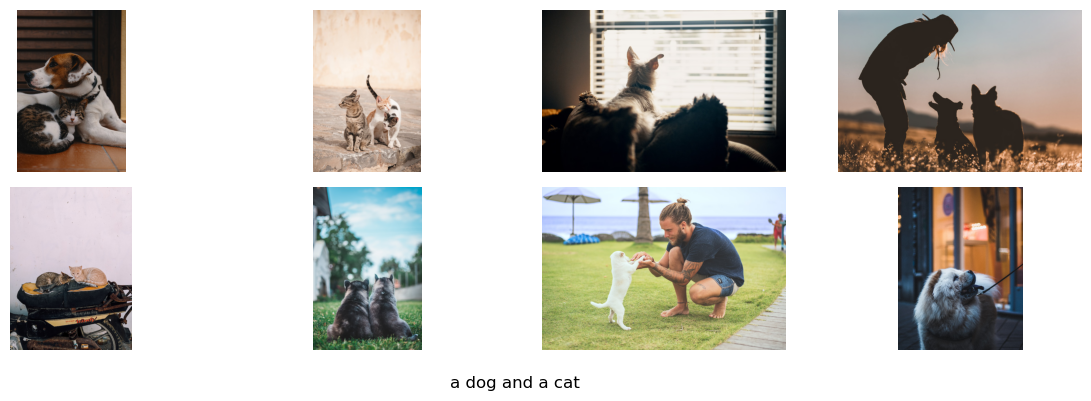

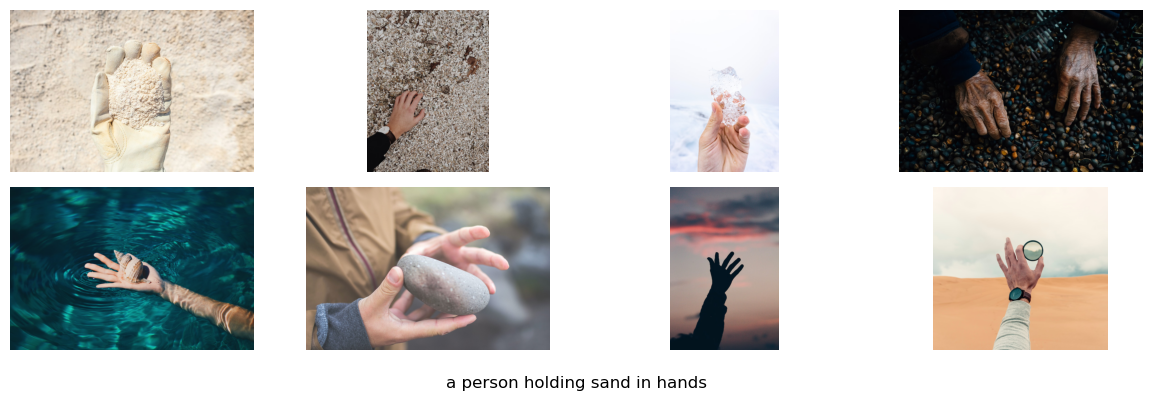

In [7]:
%%time

result = engine.query(["a dog and a cat", "a person holding sand in hands"], k=8)

CPU times: total: 4.36 s
Wall time: 32.6 s


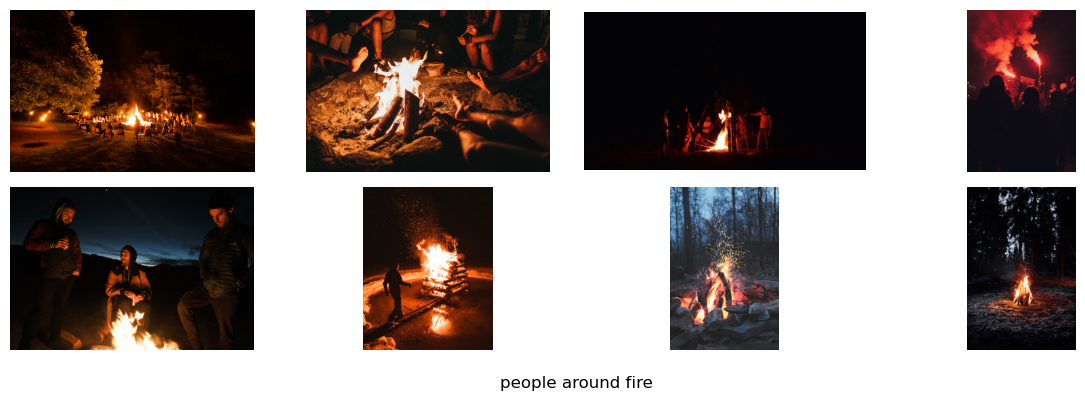

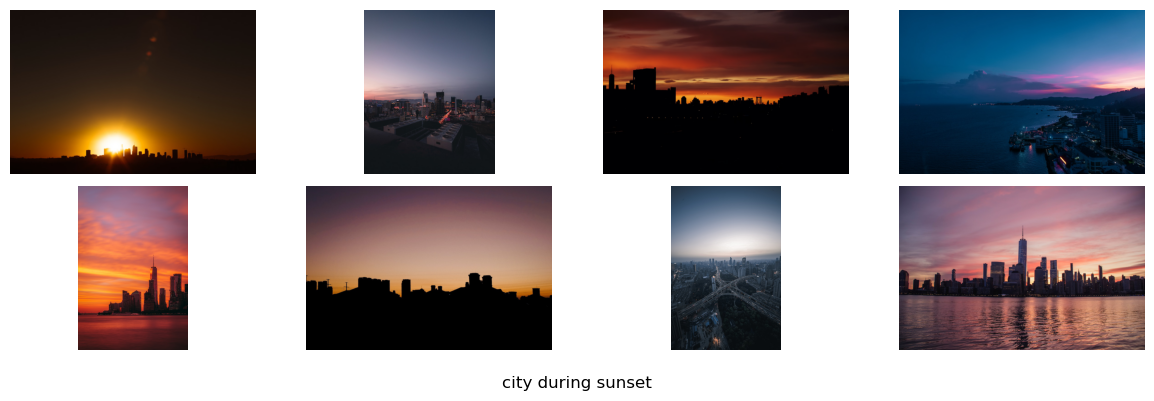

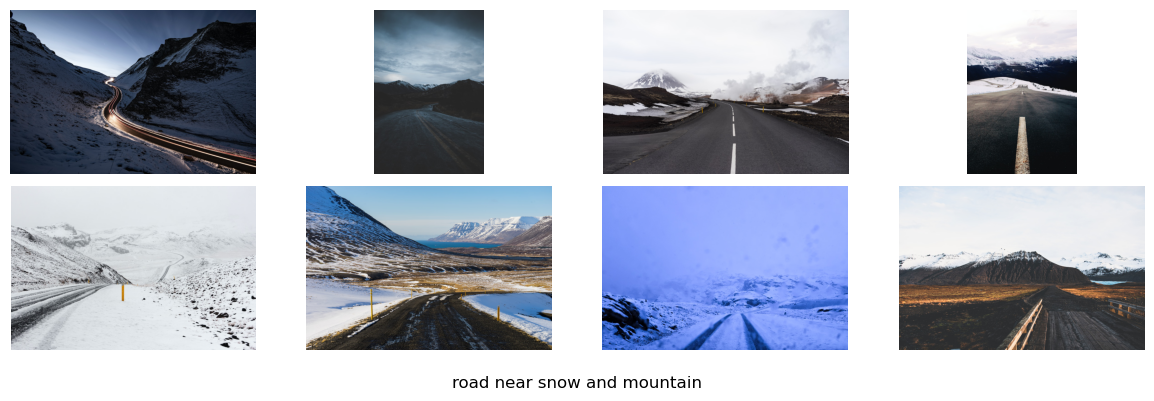

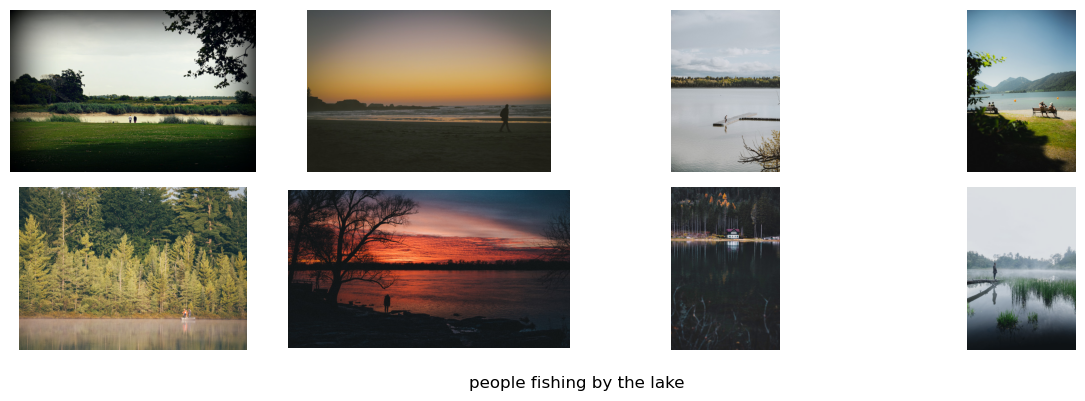

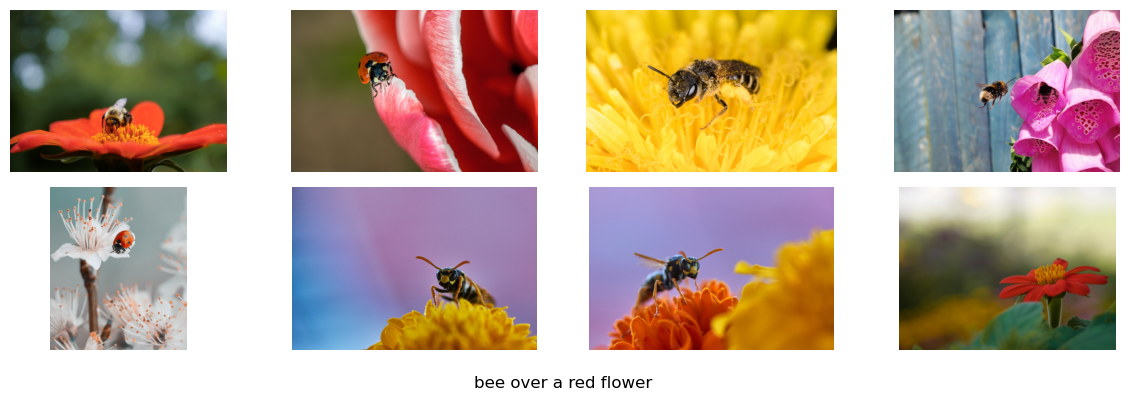

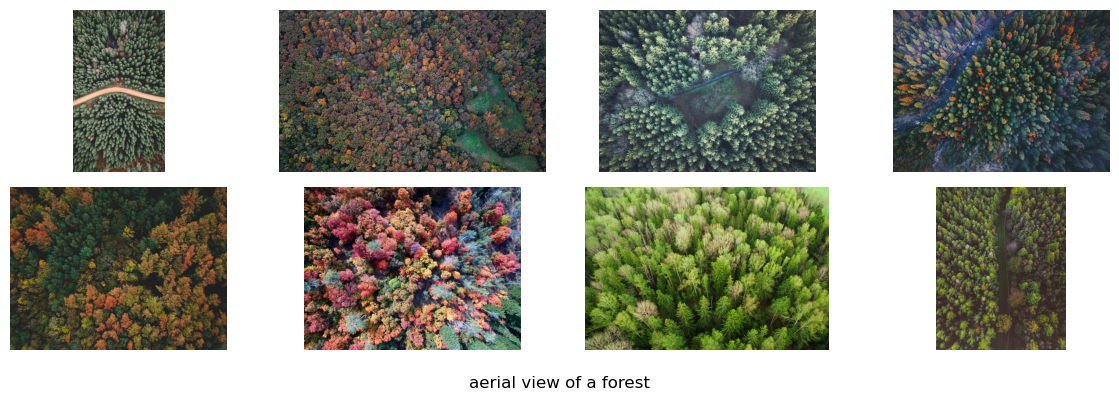

In [8]:
%%time

result = engine.query(["people around fire", "city during sunset",
                       "road near snow and mountain", "people fishing by the lake",
                       "bee over a red flower", "aerial view of a forest"], k=8)